In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.graphics.tsaplots import plot_acf

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, SimpleRNN
from keras import Input

import math

In [21]:
df = pd.read_csv('df_nivel_rios.csv')
df = df.iloc[:, 1:]

# Converter 'Data' para datetime
df['Data'] = pd.to_datetime(df['Data'])

df = df.set_index('Data')
#target = df[['Nível Guaíba (cm)']]
df

,Nível Caí (cm),Nível Jacuí (cm),Nível Sinos (cm),Nível Gravataí (cm),Nível Guaíba (cm),HORÁRIO (mm),HORARIA (°C),UMIDADE RELATIVA DO AR,VENTO
Data,,,,,,,,,
2017-11-14 12:00:00,79.0,156.0,282.0,247.0,114.0,1010.0,8.0,6.0,8.0
2017-11-14 13:00:00,77.0,156.0,280.0,246.0,114.0,1010.0,5.0,17.0,13.0
2017-11-14 14:00:00,76.0,156.0,279.0,246.0,114.0,1010.0,5.0,16.0,14.0
2017-11-14 15:00:00,76.0,156.0,277.0,246.0,114.0,1009.0,2.0,6.0,9.0
2017-11-14 16:00:00,76.0,157.0,274.0,245.0,114.0,1008.0,4.0,3.0,7.0
...,...,...,...,...,...,...,...,...,...
2024-04-19 21:00:00,86.0,181.0,252.0,278.0,104.0,1011.0,3.0,5.0,1.0
2024-04-19 22:00:00,86.0,181.0,251.0,278.0,104.0,1012.0,20.0,12.0,70.0
2024-04-19 23:00:00,86.0,181.0,249.0,278.0,104.0,1012.0,19.0,15.0,14.0


In [22]:
split_ratio = 0.75
split_index = int(len(df) * split_ratio)

train = df[:split_index]
test = df[split_index:]

scaler = MinMaxScaler()
scaler.fit(train)
train_data = scaler.transform(train)
test_data = scaler.transform(test)

In [32]:
train_data.shape

(42274, 9)

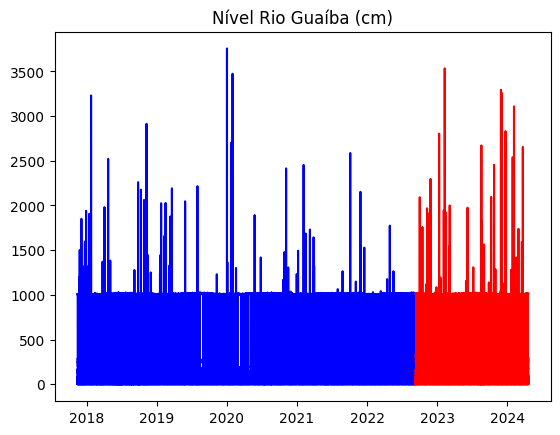

In [23]:
plt.plot(train, color='blue', label='Histórico de treinamento')
plt.plot(test, color='red', label='Histórico de teste')
plt.title('Nível Rio Guaíba (cm)')
plt.show()

In [33]:
# Define sequence length
length = 168    # 1 semana (24h * 7 dias)

batch_size = 1
# 1 beacause it's univariate
n_features = 9

generator = TimeseriesGenerator(train_data, train_data[:,4], stride=48, length=length, batch_size=batch_size)

In [34]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(length, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True, input_shape=(length, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True, input_shape=(length, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss="mse")

c:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 168, 32)        │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 168, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 168, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 168, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 168, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 168, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,681 (295.63 KB)

 Trainable params: 75,681 (295.63 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model.fit(generator, epochs=5, verbose=1)

Epoch 1/5
  1/878 ━━━━━━━━━━━━━━━━━━━━ 1:18:19 5s/step - loss: 0.1176

c:\Users\claud\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


878/878 ━━━━━━━━━━━━━━━━━━━━ 166s 184ms/step - loss: 0.0120
Epoch 2/5
878/878 ━━━━━━━━━━━━━━━━━━━━ 167s 190ms/step - loss: 0.0041
Epoch 3/5
878/878 ━━━━━━━━━━━━━━━━━━━━ 192s 219ms/step - loss: 0.0031
Epoch 4/5
878/878 ━━━━━━━━━━━━━━━━━━━━ 227s 258ms/step - loss: 0.0023
Epoch 5/5
878/878 ━━━━━━━━━━━━━━━━━━━━ 229s 260ms/step - loss: 0.0018


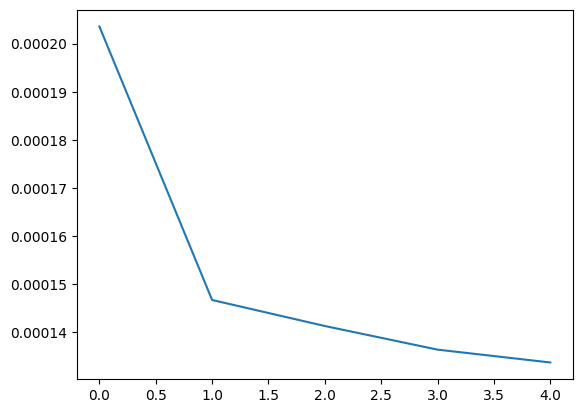

In [10]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [38]:
train_data

array([[0.1276794 , 0.23055556, 0.30615385, ..., 0.00212936, 0.046875  ,
        0.03125   ],
       [0.12395154, 0.23055556, 0.30307692, ..., 0.00133085, 0.1328125 ,
        0.04545455],
       [0.1220876 , 0.23055556, 0.30153846, ..., 0.00133085, 0.125     ,
        0.04829545],
       ...,
       [0.17800559, 0.2       , 0.32615385, ..., 0.00106468, 0.015625  ,
        0.01136364],
       [0.17614166, 0.20277778, 0.33230769, ..., 0.00106468, 0.015625  ,
        0.01136364],
       [0.17427773, 0.21111111, 0.33846154, ..., 0.00399255, 0.0390625 ,
        0.01988636]])

In [39]:
test_predictions = []

first_eval_batch = train_data[-length:, 4]
current_batch = first_eval_batch.reshape((1, length, 1))

#for i in range(len(test_data)):
for i in range(500):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    print(current_pred)
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

InvalidArgumentError: Graph execution error:

Detected at node sequential_2_1/lstm_4_1/while/body/_1/sequential_2_1/lstm_4_1/while/lstm_cell_1/MatMul defined at (most recent call last):
<stack traces unavailable>
Matrix size-incompatible: In[0]: [1,1], In[1]: [9,128]
	 [[{{node sequential_2_1/lstm_4_1/while/body/_1/sequential_2_1/lstm_4_1/while/lstm_cell_1/MatMul}}]] [Op:__inference_one_step_on_data_distributed_475866]

In [12]:
true_predictions = scaler.inverse_transform(test_predictions)
test_df = df.iloc[len(train_data):len(train_data)+500]
test_df['Predictions'] = true_predictions

C:\Users\claud\AppData\Local\Temp\ipykernel_7552\595138850.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predictions'] = true_predictions


In [13]:
train_predictions = []

first_eval_batch = test_data[:length]
current_batch = first_eval_batch.reshape((1, length, n_features))

#for i in range(len(test_data)):
for i in range(500):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    print(current_pred)
    
    # append the prediction into the array
    train_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[0.34276098]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0.31766117]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0.28784937]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0.25546575]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0.22428691]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0.19751024]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0.18407035]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0.17197801]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0.15790308]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0.14072317]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0.11962292]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0.09812184]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[0.0759019]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0.05463824]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[0.03488068]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[0.01705904]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[0.00130399]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[-0.01231013]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[-0.0238622]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18m

In [14]:
true_predictions_train = scaler.inverse_transform(train_predictions)
train_df = df.iloc[:500]
train_df['Predictions'] = true_predictions_train

C:\Users\claud\AppData\Local\Temp\ipykernel_7552\756884027.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Predictions'] = true_predictions_train


<Axes: xlabel='Data'>

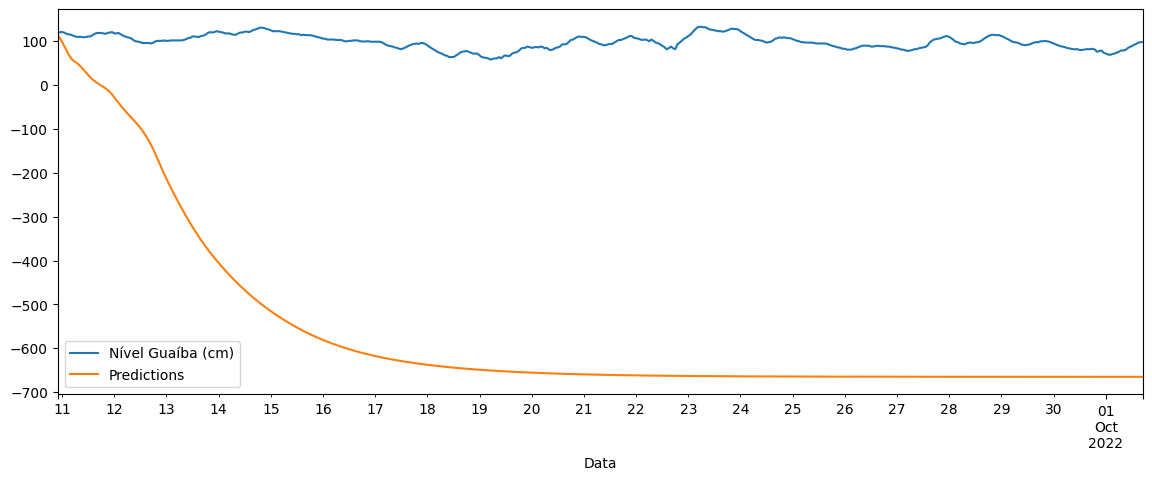

In [15]:
test_df.iloc[0:1000].plot(figsize=(14,5))

<Axes: xlabel='Data'>

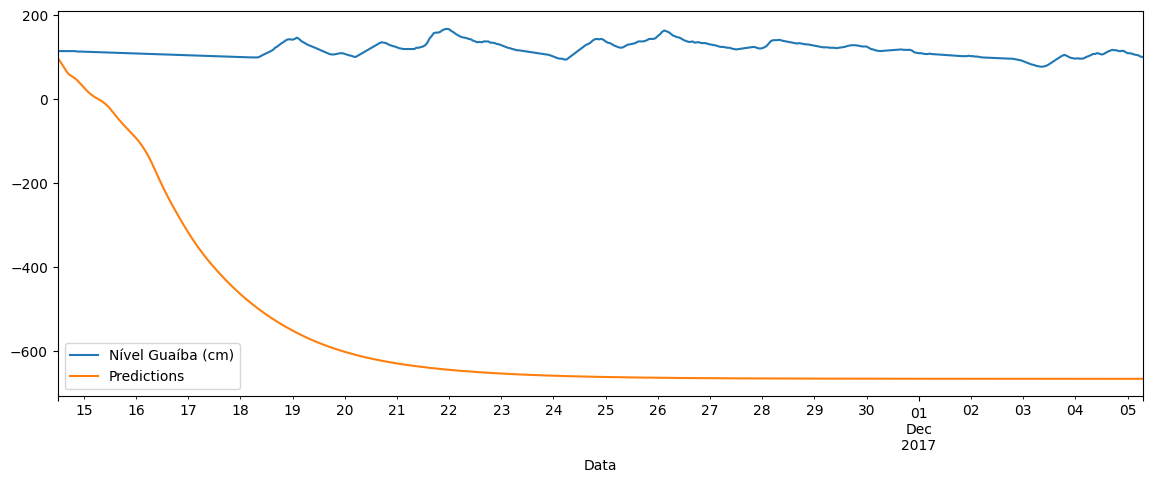

In [16]:
train_df.iloc[0:1000].plot(figsize=(14,5))

In [17]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 168    # 1 semana (antes foi tentado 1 mes)

# Create sequences for training set
X_train, y_train = create_sequences(train_data, seq_length)

# Create sequences for testing set
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape input data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

trainScore = model.evaluate(X_train, y_train, verbose=1)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(X_test, y_test, verbose=1)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

1316/1316 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 4.2765e-04
Train Score: 0.00 MSE (0.02 RMSE)
436/436 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3.6885e-04
Test Score: 0.00 MSE (0.02 RMSE)
